# Introduction to Robot Intelligence HW 2: Coding Questions

The is the coding potion of Homework 2. For submission instructions, please see the theory portion of Homework 2.

## Problem 1: Polynomial Regression with the Cross-Entropy Method

In "Tutorial 1," we worked through an example employing the cross-entropy method (CEM) for linear regression. In this problem, your task is to write a complete implementation of CEM for generalized polynomial regression. More precisely, given
* a polynomial degree $d: d ≥ 1$;
* a dataset of data pairs $(x_i, y_i)$ represented via two equal-length 1-D `numpy` arrays; and
* CEM hyperparameters `num_iters`, `elite_frac`, and `batch_size`,

your code should return the final regressed estimates for the values of each of the $(d + 1)$ coefficients of the polynomial 
\begin{align}
\hat{f}(x_i; \vec{\theta}) = \theta_{d} \cdot x_i^d + \theta_{d-1} \cdot x_i^{d-1} + ... + \theta_{1}\cdot x_i + \theta_{0}
\end{align}
minimizing the total sum of squared errors,
\begin{align}
\sum_{i} (y_i - \hat{f}(x_i; \vec{\theta}))^2
\end{align}
via the parameter vector $[\theta_0, ..., \theta_d]$. Employ a multi-dimensional Gaussian distribution with diagonal covariance as the distribution underlying parameter inference. The "starting" estimation distribution should be centered on the zero vector and have the identity as its covariance.

In [1]:
import numpy as np

In [83]:
def polynomial_regression_with_cem(x: np.ndarray, 
                                   y: np.ndarray, 
                                   d: int, 
                                   num_iters: int = 12, 
                                   elite_frac: float = 0.2, 
                                   batch_size: int = 1000):
  '''
  Inputs
    `x` (np.ndarray): a 1-D numpy array corresponding to the 'x' values of some 
      unknown function f.
    `y` (np.ndarray): a 1-D numpy array corresponding to the 'y' values of some
      unknown function f, f(x[i]) = y[i]. Has precisely the same shape as `x`.
    `d` (integer): a scalar reflecting the maximum degree of the least-squares
      polynomial whose coefficients we hope to estimate with CEM.
    `num_iters` (integer): CEM hyperparameter, the total number of CEM iterations
      to perform.
    `elite_frac` (float): CEM hyperparameter, the total proportion of "top"
      samples used to refine CEM parameter estimates at each iteration.
    `batch_size` (int): CEM hyperparameter, the total number of parameter values
      sampled from the paramter inference distribution at each iteration.
  
  Outputs
    `dummy_coeffs` (np.ndarray): a 1-D numpy array of shape (d+1,), containing the
      final estimates for each of the polynomial coefficients regressed with CEM
      after `num_iters` have been completed. Each value `dummy_coeffs[i]` should
      correspond to the degree i coefficient of the regressed polynomial.

  '''
  def get_prediction(coeffs, x):
      return np.polyval(coeffs, x)

  def mean_squared_error(y_pred, y_true):
      return np.mean((y_pred - y_true)**2)

  def sample_parameters(mean, cov, batch_size):
      return np.random.multivariate_normal(mean, cov, size=batch_size)

  def update_parameter_distribution(parameters, elite_indices):
      mean = np.mean(parameters[elite_indices], axis=0)
      cov = np.cov(parameters[elite_indices], rowvar=False)
      return mean, cov

  mean = np.zeros(d + 1)
  cov = np.identity(d + 1)
  
  for i in range(num_iters):
      parameters = sample_parameters(mean, cov, batch_size)
      predictions = [get_prediction(coeffs, x) for coeffs in parameters]
      errors = [mean_squared_error(y_pred, y) for y_pred in predictions]
      elite_indices = np.argsort(errors)[:int(batch_size * elite_frac)]
      mean, cov = update_parameter_distribution(parameters, elite_indices) 
  dummy_coeffs = mean
  
  assert isinstance(dummy_coeffs, np.ndarray) and (dummy_coeffs.shape == (d+1,)) 
  return dummy_coeffs

In [85]:
def sample_test(f):
  x = np.array([[1, 2.5, 3.5, 4, 5, 7, 8.5]])
  y = np.array([[0.3, 1.1, 1.5, 2.0, 3.2, 6.6, 8.6]])
  d = 1

  out = f(x, y, d, num_iters=20, elite_frac=0.005, batch_size = 1000)
  assert np.allclose(out, [1.03571252, -1.19191605], rtol=1)

sample_test(polynomial_regression_with_cem)

## Problem 2: Classifying Prime Numbers from MNIST

In "Tutorial 2," we saw how to set up a simple Neural Network training loop with PyTorch by following the PyTorch CIFAR10 tutorial. There are many other datasets available through `torchvision`, including the famous [MNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html) (short for "Modified National Institute of Standards and Technology" database). This is a large database of handwritten digits, consisting of images and "groundtruth" labels, that is commonly used for training image processing systems to identify numbers from images. 

Let's download copies of the training and testing portions of this dataset locally.

In [4]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We can inspect the dimensions of each of these dataset just by calling their `__tostr__` methods.

In [5]:
print(train_data), print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


(None, None)

Now, let's visualize some of the training data images alongside their labels.

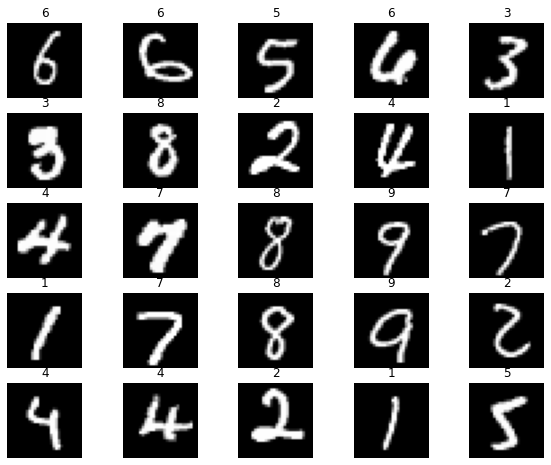

In [6]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Your task in this problem is to write a training loop that produces a neural network classifier **trained to distinguish prime digits from non-prime digits**. In other words, given an image of a handwritten 1, 2, 3, 5, or 7, your classifier should be trained to output "1" (i.e. a judgement of "prime"). Conversely, given an image of a handwritten 0, 4, 6, 8, or 9, your classifier should be trained to output "0" (i.e. a judgement of "not prime"). 

Your code should use [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (SGD) to optimize parameter values, and [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) (BCE) as the training criterion.

You may consult online materials when writing your code. Recall the fundamental litmus test for a correct supervised learning training loop is that it must satisfy two criteria: the value of the loss associated with the model's prediction decreases with training iterations, and the prediction accuracy of the model on *both* the train and test datasets increases with training iterations. You are encouraged to track these quantities via `print` statements while writing your code. Do keep in mind that we **NEVER TRAIN ON THE TEST SET** in supervised learning.

In [7]:
import torch.nn as nn

class CNN(nn.Module):
    '''*********** DO NOT MODIFY THIS CODE **********'''
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 2) # model outputs have dimension 2

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x  
    ''' ******** DO NOT MODIFY THIS CODE **********'''

net = CNN()

In [54]:
import torch.optim as optim

def train(
    net,
    train_data,
    test_data,
    num_epochs: int = 20,
    batch_size: int = 32,
    lr: float = 0.001,
    momentum: float = 0.9):
  
  '''
  Inputs
    `net` (torch.nn.Module): an instance of the `CNN` class defined above.
    `train_data` (torchvision.datasets.MNIST): a torchvision dataset object of 
      MNIST training examples.
    `test_data` (torchvision.datasets.MNIST): a torchvision dataset object of 
      MNIST test examples.
    `num_epochs` (integer): The number of epochs for which to train and test
      the model.
    `batch_size` (integer): the number of data pairs (x, y) used for computing
      loss + loss gradients with SGD at each iteration of training.
    `lr` (float): the learning rate associated with SGD.
    `momentum` (float): the momentum associated with SGD.
  
  Outputs
    `net` (torch.nn.Module): the same CNN object input into this function,
      trained for `num_epochs` with binary cross entropy loss and SGD with batch 
      size `batch_size` + learning rate `lr` + momentum `momentum` to identify
      handwritten *prime numbers*.

  '''
  
  ## Initialize optimizer
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

  ## Set "train" mode "on"
  net.train()

  ## Create dataloaders
  dummy_dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    'test': torch.utils.data.DataLoader(test_data, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        num_workers=1),
  }

  ## Initialize dataloader

  ## Main loop goes here
  for epoch in range(num_epochs):
    for mode in ['train', 'test']:
      running_loss = 0.0
      running_corrects = 0
      total_samples = 0
      for i, (images, labels) in enumerate(dummy_dataloaders[mode]):
        if mode == 'train':
          net.train()
        else:
          net.eval()

        ## Forward pass
        outputs, _ = net(images)
        layer = nn.Softmax(dim=1)
        outputs = layer(outputs)

        ## Compute loss
        prime_digits = [1, 2, 3, 5, 7]
        targets = torch.tensor([int(label in prime_digits) for label in labels])
        loss = nn.functional.binary_cross_entropy_with_logits(outputs[:, 1], targets.float())

        ## Zero-out parameter gradients
        optimizer.zero_grad()

        ## Compute gradients
        loss.backward()

        ## Update parameters
        optimizer.step()

        ## Compute accuracy
        preds = torch.argmax(outputs, dim=1)
        corrects = torch.sum(preds == targets)
        running_corrects += corrects.item()
        total_samples += len(images)
        if i % 300 == 0 and i > 0:
          acc = running_corrects / total_samples
          print(f'{mode} epoch {epoch}, iter {i}, loss {loss.item():.4f}, acc {acc:.4f}')
  
  ## Return trained network
  return net

In [55]:
# Train the CNN model using the train() function
train(net, train_data, test_data, num_epochs=5, batch_size=32, lr=0.001, momentum=0.9)

train epoch 0, iter 300, loss 0.5160, acc 0.9882
train epoch 0, iter 600, loss 0.5464, acc 0.9880
train epoch 0, iter 900, loss 0.5512, acc 0.9875
train epoch 0, iter 1200, loss 0.5401, acc 0.9876
train epoch 0, iter 1500, loss 0.4441, acc 0.9879
train epoch 0, iter 1800, loss 0.4842, acc 0.9880
test epoch 0, iter 300, loss 0.4451, acc 0.9894
train epoch 1, iter 300, loss 0.5670, acc 0.9885
train epoch 1, iter 600, loss 0.5543, acc 0.9894
train epoch 1, iter 900, loss 0.5368, acc 0.9892
train epoch 1, iter 1200, loss 0.5428, acc 0.9884
train epoch 1, iter 1500, loss 0.5383, acc 0.9886
train epoch 1, iter 1800, loss 0.4678, acc 0.9885
test epoch 1, iter 300, loss 0.4915, acc 0.9896
train epoch 2, iter 300, loss 0.4810, acc 0.9894
train epoch 2, iter 600, loss 0.4800, acc 0.9888
train epoch 2, iter 900, loss 0.4322, acc 0.9886
train epoch 2, iter 1200, loss 0.5274, acc 0.9887
train epoch 2, iter 1500, loss 0.5060, acc 0.9887
train epoch 2, iter 1800, loss 0.4567, acc 0.9885
test epoch 2,

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=2, bias=True)
)